# Topic Modeling

![](../figs/intro_nlp/topic/entelecheia_grouping.png)

## Topic Models

- summarize unstructured text
- use words within document to infer subject
- useful for dimension reduction
- topic models are more interpretable than other dimension reduction methods, such as PCA.


## Latent Dirichlet Allocation (LDA)

![](../figs/intro_nlp/topic/14.png)


`Latent` means hidden, `Dirichlet` is a type of probability distribution. Latent Dirichlet Allocation means that we are trying to find all the probability distributions and they are hidden.

Latent Dirichlet Allocation (LDA):

- Each topic is a distribution over words.
- Each document is a distribution over topics.

Input: $N \times M$ document-term count matrix $X$

Assume: there are $K$ topics (tunable hyperparameter, use coherence).

Like PCA or NMF, LDA works by factorizing $X$ into:

- an $N \times K$ document-topic matrix
- an $K \times M$ topic-term matrix


When we fit these 4 questions to LDA, it will give us back something like this:

![](../figs/intro_nlp/topic/16.png)

The 1st question is 100% of Topic A, the 3rd question is 100% of Topic B, and the last question is split of Topic A and Topic B.


The word “football” has the highest weight in Topic A, followed by “NFL” followed by “player”. So we could infer that this topic is about sport.

The word “politics” has the highest weight in Topic B, followed by “leader”, followed by “world”. So we could infer that this topic is about politics. As shown below:

- Topic A: 40% football, 30% NFL, 10% player … Sport
- Topic B: 30% political, 20% leader, 10% world … Politics


Then we go back to our original questions, here are the topics!

![](../figs/intro_nlp/topic/17.png)

To dive a little deeper, every questions is a mix of topics, and every topic is a mix of words.

![](../figs/intro_nlp/topic/18.png)


A question is a probability distribution of topics, and every topic is a probability distribution of words.

What LDA does is that when you fit it with all those questions, it is trying its best to find the best topic mix and the best word mix.


## Non-negative Matrix Factorization (NMF)

We take the term-document matrix, decompose to two matrices, first one has every topic and what terms in it, and 2nd one has every document and what topics in it.

![](../figs/intro_nlp/topic/19.png)


On the left we have 3 questions, on the right we have term-document matrix for these 3 questions. We choose k=2 topics.

![](../figs/intro_nlp/topic/20.png)


After decomposition, we got two non-negative matrices of the original n words by k topics and those same k topics by the m original documents.


![](../figs/intro_nlp/topic/21.png)

## Topic Modeling Example using NMF and SVD

### The problem

**term-document matrix**:

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure.  It's an example of a **bag of words** approach.

![](../figs/intro_nlp/topic/document_term.png)

source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#)

### Motivation

Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics. 

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them.  Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**

- [Data source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html): Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.

In [65]:
%config InlineBackend.figure_format='retina'
import numpy as np
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [66]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [67]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Let's look at some of the data.  Can you guess which category these messages are in?

In [68]:
print("\n".join(newsgroups_train.data[:2]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.


In [69]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

The target attribute is the integer index of the category.

In [70]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [71]:
num_topics, num_top_words = 6, 8

### Stopwords, stemming, lemmatization

#### Stopwords
From [Intro to Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html):

*Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words.*

*The general trend in IR systems over time has been from standard use of quite large stop lists (200-300 terms) to very small stop lists (7-12 terms) to no stop list whatsoever. Web search engines generally do not use stop lists.*

In [72]:
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')
print(len(STOPWORDS))
print(STOPWORDS[:10])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


#### Stemming and Lemmatization

from [Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) textbook:

Are the below words the same?

*organize, organizes, and organizing*

*democracy, democratic, and democratization*

Stemming and Lemmatization both generate the root form of the words. 

Lemmatization uses the rules about a language.  The resulting tokens are all actual words

"Stemming is the poor-man’s lemmatization." (Noah Smith, 2011) Stemming is a crude heuristic that chops the ends off of words.  The resulting tokens may not be actual words. Stemming is faster.

In [73]:
from nltk import stem

wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

word_list = ['feet', 'foot', 'foots', 'footing']

In [74]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [75]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

### Data Processing

Next, scikit learn has a method that will extract all the word counts for us.  In the next lesson, we'll learn how to write our own version of CountVectorizer, to see what's happening underneath the hood.

In [76]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())

vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)

print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [37]:
vocab = np.array(vectorizer.get_feature_names_out())
vocab.shape

(26576,)

In [83]:
vocab[-10:]

array(['zurich', 'zurvanism', 'zus', 'zvi', 'zwaartepunten', 'zwak',
       'zwakke', 'zware', 'zwarte', 'zyxel'], dtype=object)

### Singular Value Decomposition (SVD)

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).


SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis

![](../figs/intro_nlp/topic/svd_fb.png)

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))


Latent Semantic Analysis (LSA) uses SVD.

In [84]:
%%time 
U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 24min 42s, sys: 28min 17s, total: 52min 59s
Wall time: 25.7 s


In [85]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


What can we say about the singular values s?

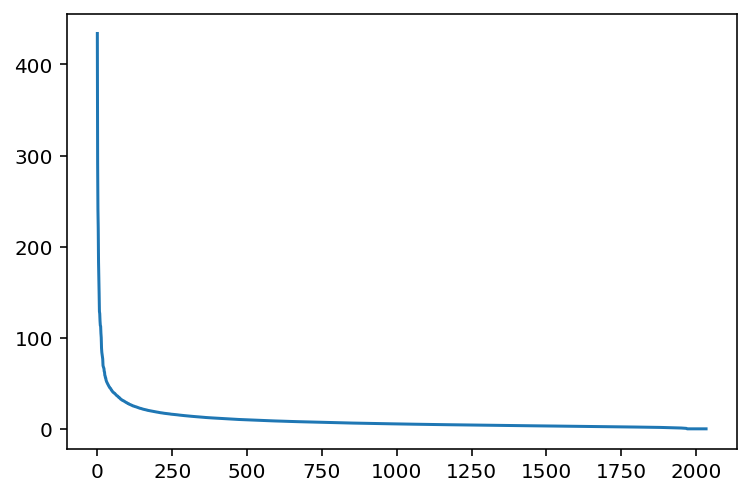

In [86]:
plt.plot(s);

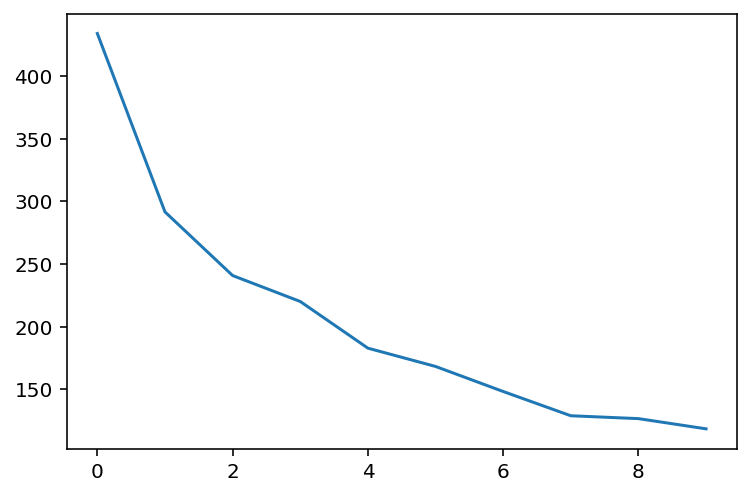

In [44]:
plt.plot(s[:10]);

In [87]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [88]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised algorithm** - which is to say, we never actually told the algorithm how our documents are grouped.

### Non-negative Matrix Factorization (NMF)

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

![](../figs/intro_nlp/topic/nmf_doc.png)

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

#### NMF Applications

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling

#### NMF from sklearn

In [89]:
%%time
m, n = vectors.shape
d = 5  # num topics

clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(np.asarray(vectors))
H1 = clf.components_

CPU times: user 4min 4s, sys: 3min 28s, total: 7min 32s
Wall time: 3.96 s


In [90]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

#### NMF in summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:
- For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
- Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

### Truncated SVD


We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD.  We are just interested in the vectors corresponding to the **largest** singular values.

#### Shortcomings of classical algorithms for decomposition:

- Matrices are "stupendously big"
- Data are often **missing or inaccurate**.  Why spend extra computational resources when imprecision of input limits precision of the output?
- **Data transfer** now plays a major role in time of algorithms.  Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
- Important to take advantage of **GPUs**.

#### Advantages of randomized algorithms:

- inherently stable
- performance guarantees do not depend on subtle spectral properties
- needed matrix-vector products can be done in parallel

(source: [Halko](https://arxiv.org/abs/0909.4061))

#### Timing comparison

In [91]:
%%time 
u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 22min 10s, sys: 36min 12s, total: 58min 23s
Wall time: 28.3 s


In [92]:
%%time 
u, s, v = decomposition.randomized_svd(vectors, n_components=10, random_state=123)

CPU times: user 1min 47s, sys: 4min 3s, total: 5min 50s
Wall time: 4.16 s


## Document Clustering


### Cosine Similarity

- Representatio nof document $i$ as a vector $x_i$
  - for example $x_i$ = term counts or $x_i$ = IDF-weighted term frequencies
- Each document is a non-negative vector in an $n_x$-space, where $n_x$ = vocabulary size
  - documents are rays, and similar documents have similar vectors
- Can measure similarity between documents $i$ and $j$ by the cosine of the angle between $x_i$ and $x_j$:
  - With perfectly collinear documents (that is, $x_i = α x_j$, $α \gt 0$), $cos(0) = 1$
  - For orthogonal documents (no words in common), $cos(\pi/2)=0$


- Cosine similarity is computable as the normalized dot product between the vectors:

    $ cos\_sim(x_1,x_2) = \frac{x_1 \cdot x_2}{\|x_1\|\|x_2\|}$
  

```python
from sklearn.metrics.pairwise import cosine_similarity
# between two vectors:
sim = cosine_similarity(x, y)[0,0]
# between all rows of a matrix:
sims = cosine_similarity(X)
```


### Cosine Similarity Example

![](../figs/intro_nlp/topic/2.png)


![](../figs/intro_nlp/topic/3-800x852.png)


### Dimensionality Reduction

- Datasets are not distributed uniformly across the feature space.
- They have a lower-dimensional latent structure – a manifold – that can be learned.
- `Dimensonality reduction` makes data more interpretable – for example by projecting down to two dimensions for visualization.
- improves computational tractability.
- can improve model performance.


### Swiss Roll reduction with LLE

In [9]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import manifold, datasets

X, color = datasets.make_swiss_roll(n_samples=1500)

print("Computing LLE embedding")
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2)
print("Done. Reconstruction error: %g" % err)

Computing LLE embedding
Done. Reconstruction error: 1.23163e-07


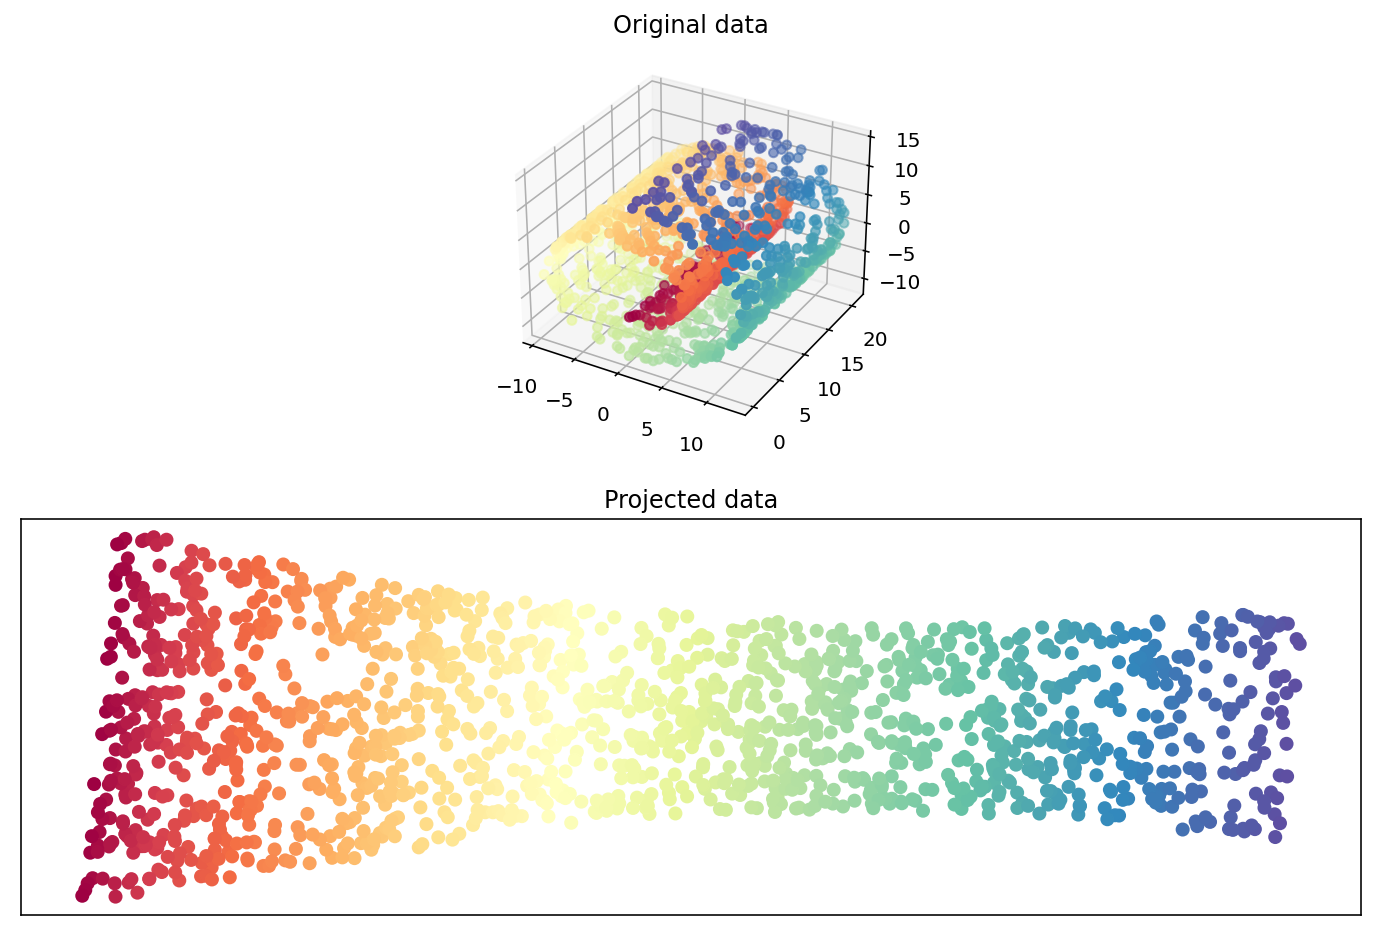

In [12]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(211, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")
ax = fig.add_subplot(212)
ax.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("Projected data")
plt.show()

### PCA (principal component analysis) / SVD (singular value decompositio)

- PCA computes the dimension in data explaining most variance.
- after the first component, subsequent components learn the (orthogonal) dimensions explaining most variance in dataset after projecting out first component.

```python
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
```


![](../figs/intro_nlp/topic/8.png)


![](../figs/intro_nlp/topic/9.png)


### PCA/NMF for Dimension Reduction

Data can be reduced by projecting down to first principal component dimensions.

- Distance metrics between observations (e.g. cosine similarity) are approximately preserved.
- For supervised learning, reduced matrix be used as predictors instead of the original matrix.
  - but might destroy (a lot of) predictive information in your dataset.
  - compromise: use feature selection to keep strong predictors, and take principal components of weak predictors.
- PCA dimensions are not interpretable.
- For non-negative data (e.g. counts or frequencies), Non-negative Matrix Factorization (NMF) provides more interpretable factors than PCA.


### k-means clustering

- Matrix of predictors treated as a Euclidean space (should standardize all columns)
- algorithm: initialize cluster centroids randomly, then shift around to minimize sum of within-cluster squared distance

```python
from sklearn.cluster import Kmeans
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
assigned_cluster = kmeans.labels_
```


![](../figs/intro_nlp/topic/10.png)


![](../figs/intro_nlp/topic/11.png)


### Other clustering algorithms

- “k-medoid” clustering use L1 distance rather than Euclidean distance; produces the “medoid” (median vector) for each cluster rather than “centroid” (mean vector).
  - less sensitive to outliers, and medoid can be used as representative data point.
- DBSCAN defines clusters as continous regions of high density.
  - detects and excludes outliers automatically
- Agglomerative (hierarchical) clustering makes nested clusters.
